In [1]:
from collections import defaultdict
from pathlib import Path

from IPython.display import (
    display,
    Markdown,
)
import pandas as pd
import seaborn as sns
import os

from howso.nominal_substitution.substitution_engine import NominalSubstitutionEngine
from howso.synthesizer import Synthesizer
from howso.utilities import infer_feature_attributes
from howso.validator import Validator
from howso.validator.results import ValidatorResult


os.environ["LANG"] = "en_US.UTF-8"
os.environ["LC_ALL"] = "en_US.UTF-8"

# Set this to True if the dataset is deemed to already have been anonymized.
ALREADY_ANONYMIZED: bool = True

In [2]:
col_type_mapping = {
    'nih_record_id': 'string', 'nih_race': 'Int64', 'nih_ethnicity': 'Int64',
    'nih_age': 'Int64', 'nih_sex': 'Int64', 'nih_zip': 'string', 'nih_insurance': 'Int64',
    'nih_vaping_yn': 'Int64', 'nih_nicotine_yn': 'Int64', 'nih_alcohol_yn': 'Int64',
    'nih_asthma': 'Int64', 'nih_cancer': 'Int64', 'nih_cardiovascular_disease': 'Int64',
    'nih_chronic_kidney_disease': 'Int64', 'nih_chronic_lung_disease': 'Int64',
    'nih_diabetes': 'Int64', 'nih_hypertension': 'Int64',
    'nih_immunosuppressive_condition': 'Int64', 'nih_serious_mental_illness': 'Int64',
    'nih_sickle_cell_disease': 'Int64', 'nih_pregnancy': 'Int64', 'nih_height': 'Int64',
    'nih_weight': 'Int64', 'patient_data_date': 'string',
    'patient_covid_test_complete': 'string', 'covid_test_result': 'Int64',
    'covid_test_type': 'Int64', 'patient_stay_length': 'Int64',
    'patient_ventilator': 'Int64', 'patient_icu': 'Int64', 'patient_remdesivir_use': 'Int64',
    'patient_mortality': 'Int64', 'country': 'Int64'
}
print(f'total number of columns being mapped: {len(col_type_mapping)}')

data_path = Path("/home", "sagemaker-user", "phs002525", "rad_015_941-01_deidentified_clinicaldata_DATA_transformcopy_v1_processed.csv")
df = pd.read_csv(data_path, dtype=col_type_mapping)
df = df.reset_index(drop=True)
print(df.columns)
print(f'total number of rows: {len(df)}')

# for model comparison for covid_test_result prediction, nulls from target feature should be removed and all-null columns should be removed as well
target_feature = 'patient_stay_length'
df = df.dropna(subset=[target_feature])
print(f'after removing null rows, df.shape: {df.shape}')
null_only_cols = df.columns[df.isna().all()].tolist()
print(null_only_cols)
df = df.drop(columns=null_only_cols)
df = df.reset_index(drop=True)
print(df.shape)
pd.set_option('display.max_columns', None)
df.describe()

total number of columns being mapped: 33
Index(['nih_race', 'nih_ethnicity', 'nih_age', 'nih_sex', 'nih_zip',
       'nih_insurance', 'nih_vaping_yn', 'nih_nicotine_yn', 'nih_alcohol_yn',
       'nih_asthma', 'nih_cancer', 'nih_cardiovascular_disease',
       'nih_chronic_kidney_disease', 'nih_chronic_lung_disease',
       'nih_diabetes', 'nih_hypertension', 'nih_immunosuppressive_condition',
       'nih_serious_mental_illness', 'nih_sickle_cell_disease',
       'nih_pregnancy', 'nih_height', 'nih_weight', 'patient_stay_length',
       'patient_ventilator', 'patient_icu', 'patient_remdesivir_use',
       'patient_mortality', 'country'],
      dtype='object')
total number of rows: 7285
after removing null rows, df.shape: (7285, 28)
[]
(7285, 28)


,nih_race,nih_ethnicity,nih_age,nih_sex,nih_insurance,nih_vaping_yn,nih_nicotine_yn,nih_alcohol_yn,nih_asthma,nih_cancer,nih_cardiovascular_disease,nih_chronic_kidney_disease,nih_chronic_lung_disease,nih_diabetes,nih_hypertension,nih_immunosuppressive_condition,nih_serious_mental_illness,nih_sickle_cell_disease,nih_pregnancy,nih_height,nih_weight,patient_stay_length,patient_ventilator,patient_icu,patient_remdesivir_use,patient_mortality,country
count,7134.0,7135.0,7285.0,7285.0,7285.0,7285.0,7285.0,7285.0,7285.0,7285.0,7285.0,7285.0,7285.0,7285.0,7285.0,7285.0,7285.0,7285.0,7285.0,5706.0,5711.0,7285.0,7285.0,7285.0,7285.0,7285.0,7285.0
mean,4.455985,0.606167,58.128483,0.495813,1.231846,0.11105,0.348936,0.047632,0.133288,0.380782,0.727385,0.441592,0.26685,0.352231,0.617296,0.026356,0.21757,0.010158,0.0,66.067648,180.74838,6.755388,0.087165,0.141112,0.250789,0.096088,0.05779
std,0.968281,0.488633,18.123144,1.225592,0.42204,0.314216,0.476666,0.213001,0.339909,0.485613,0.445335,0.496611,0.442344,0.477698,0.48608,0.160201,0.412622,0.10028,0.0,3.93679,48.240055,12.667603,0.282097,0.348161,0.433497,0.294732,0.869954
min,1.0,0.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,3.0,0.0,44.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,148.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,5.0,1.0,59.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,66.0,174.0,1.0,0.0,0.0,0.0,0.0,0.0
75%,5.0,1.0,72.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,69.0,205.0,8.0,0.0,0.0,1.0,0.0,0.0
max,6.0,1.0,90.0,96.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,80.0,500.0,151.0,1.0,1.0,1.0,1.0,18.0


In [3]:
continuous_feats: list[str] = [
    'nih_age', 'nih_height', 'nih_weight', 'patient_stay_length'
]

# These features have been decided to be personally-identifying and, if they
# have not already been anonymized, will be replaced with novel nominals.
sensitive_nominal_feats: dict[str, str] = {
    "country": "int-id",
    "nih_zip": "int-id"
}

# These are non-personally-identifying nominals. Their values may be present in
# the resulting synthetic data, but necessary to maintain the predictiveness of
# the resulting synthetic data.
nominal_feats: list[str] = [
    'nih_race', 'nih_ethnicity', 'nih_sex',
    'nih_insurance', 'nih_vaping_yn', 'nih_nicotine_yn', 'nih_alcohol_yn',
    'nih_asthma', 'nih_cancer', 'nih_cardiovascular_disease',
    'nih_chronic_kidney_disease', 'nih_chronic_lung_disease',
    'nih_diabetes', 'nih_hypertension', 'nih_immunosuppressive_condition',
    'nih_serious_mental_illness', 'nih_sickle_cell_disease', 'nih_pregnancy', 
    'patient_ventilator', 'patient_icu', 'patient_remdesivir_use', 'patient_mortality'
]

In [4]:
# Compute feature attributes
features = infer_feature_attributes(
    df,
    types={
        "continuous": continuous_feats,
        "nominal": list(sensitive_nominal_feats.keys()) + nominal_feats
    },
    # Let's use tight-bounds for the continuous
    tight_bounds=continuous_feats,
)

# Non-sensitive nominals should be marked as such
for nominal in nominal_feats:
    features[nominal]["non_sensitive"] = True

if ALREADY_ANONYMIZED:
    # If data is already anonymized, mark the "sensitive" features non-sensitive too.
    for nominal in sensitive_nominal_feats.keys():
        features[nominal]["non_sensitive"] = True
else:
    # Let's mark the sensitive nominals with the desired subtypes
    for nominal, subtype in sensitive_nominal_feats.items():
        features[nominal]["subtype"] = subtype

features.to_dataframe()


type decimal_places     bounds        \
                                                           allow_null   min   
nih_race                            nominal            0.0       True   NaN   
nih_ethnicity                       nominal            0.0       True   NaN   
nih_age                          continuous            0.0       True  21.0   
nih_sex                             nominal            0.0       True   NaN   
nih_zip                             nominal            NaN       True   NaN   
nih_insurance                       nominal            0.0       True   NaN   
nih_vaping_yn                       nominal            0.0       True   NaN   
nih_nicotine_yn                     nominal            0.0       True   NaN   
nih_alcohol_yn                      nominal            0.0       True   NaN   
nih_asthma                          nominal            0.0       True   NaN   
nih_cancer                          nominal            0.0       True   NaN   
nih_cardiovascular_disease          nominal            0.0       True   NaN   
nih_chronic_kidney_disease          nominal            0.0       True   NaN   
nih_chronic_lung_disease            nominal            0.0       True   NaN   
nih_diabetes                        nominal            0.0       True   NaN   
nih_hypertension                    nominal            0.0       True   NaN   
nih_immunosuppressive_condition     nominal            0.0       True   NaN   
nih_serious_mental_illness          nominal            0.0       True   NaN   
nih_sickle_cell_disease             nominal            0.0       True   NaN   
nih_pregnancy                       nominal            0.0       True   NaN   
nih_height                       continuous            0.0       True  48.0   
nih_weight                       continuous            0.0       True  79.0   
patient_stay_length              continuous            0.0       True   0.0   
patient_ventilator                  nominal            0.0       True   NaN   
patient_icu                         nominal            0.0       True   NaN   
patient_remdesivir_use              nominal            0.0       True   NaN   
patient_mortality                   nominal            0.0       True   NaN   
country                             nominal            0.0       True   NaN   

                                                                 data_type  \
                                   max observed_min observed_max             
nih_race                           NaN          NaN          NaN    number   
nih_ethnicity                      NaN          NaN          NaN    number   
nih_age                           90.0         21.0         90.0    number   
nih_sex                            NaN          NaN          NaN    number   
nih_zip                            NaN          NaN          NaN    string   
nih_insurance                      NaN          NaN          NaN    number   
nih_vaping_yn                      NaN          NaN          NaN    number   
nih_nicotine_yn                    NaN          NaN          NaN    number   
nih_alcohol_yn                     NaN          NaN          NaN    number   
nih_asthma                         NaN          NaN          NaN    number   
nih_cancer                         NaN          NaN          NaN    number   
nih_cardiovascular_disease         NaN          NaN          NaN    number   
nih_chronic_kidney_disease         NaN          NaN          NaN    number   
nih_chronic_lung_disease           NaN          NaN          NaN    number   
nih_diabetes                       NaN          NaN          NaN    number   
nih_hypertension                   NaN          NaN          NaN    number   
nih_immunosuppressive_condition    NaN          NaN          NaN    number   
nih_serious_mental_illness         NaN          NaN          NaN    number   
nih_sickle_cell_disease            NaN          NaN          NaN    number   
nih_pregnancy                 

In [5]:
if not ALREADY_ANONYMIZED:
    # Before continuing, let's substitute sensitive features with replacement nominals.

    # Instantiate the NominalSubstitutionEngine
    substitution_engine = NominalSubstitutionEngine.factory(nominal_substitution_config={
        "nominals": {"default": {"locales": ["en_US"], "substitution": "naive"}},
    })
    df = substitution_engine.apply_substitutions(features, df)

    # Now that these replacements have been made, we no longer need these marked as sensitive.
    for feature in sensitive_nominal_feats.keys():
        features[feature]["subtype"] = None
        features[feature]["non_sensitive"] = True

    # Display the new dataframe and feature attributes
    display(df)
    display(features.to_dataframe())


In [6]:
# desired_conviction_list = [0.1, 0.5, 1.0, 3.0, 5.0, 10.0, 25.0]
desired_conviction_list = [50.0, 100.0]
synthed_dfs: list[pd.DataFrame] = []
validator_results: list[ValidatorResult] = []
metrics = [
    # This provides a privacy metric
    "AnonymityPreservation",
    # These are the 3 most typical used for Accuracy metrics
    "DescriptiveStatistics",
    "JointProbability",
    "ModelComparison",   # This will give us more detailed, per-feature accuracy metrics.
]

# Move desired_conviction loop out to the top so that we don't re-train the
# same trainee over and over.
for desired_conviction in desired_conviction_list:
    display(Markdown(f"## Processing desired_conviction={desired_conviction}"))

    with Synthesizer(privacy_override=True, use_id_privacy=False) as s:
        s.train(df, features=features)

        synth_df = s.synthesize_cases(
            n_samples=df.shape[0],
            desired_conviction=desired_conviction,
            # generate_new_cases="always"
            generate_new_cases="no"
        )
        synthed_dfs.append(synth_df)
        synth_df.to_csv(f'data/wastewater_clinical/gen_new_case_no/synthesized_{desired_conviction}.csv', 
                        index=False)
        with Validator(s, synth_df) as v:
            results = v.run_metrics(metrics)
        validator_results.append(results)

## Processing desired_conviction=50.0

Version 50.3.1 of Howso Engine™ is available. You are using version 50.2.1.


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=4.906
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=3.204
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.465
Run finished with overall_desirability=4.328


## Processing desired_conviction=100.0

Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=4.877
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=3.036
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.503
Run finished with overall_desirability=4.273


In [7]:
# Display the full metric details for each desirability_conviction level
for desired_conviction, synth_df, results in zip(desired_conviction_list, synthed_dfs, validator_results, strict=True):
    display(Markdown(f"## {desired_conviction=}"))
    for metric_name, result in results.items():
        display(metric_name)
        display(result.get_dataframe())

## desired_conviction=50.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,4.535479,0,1.813447,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,nih_chronic_lung_disease,entropy,0.5801,4.849516
1,1,generated,nih_chronic_lung_disease,entropy,0.5629,4.849516
2,1,original,nih_chronic_lung_disease,uniques,2.0,5.000000
3,1,generated,nih_chronic_lung_disease,uniques,2.0,5.000000
4,1,original,nih_chronic_lung_disease,mode,0.0,NaN
...,...,...,...,...,...,...
219,1,generated,nih_cardiovascular_disease,entropy,0.602685,4.858287
220,1,original,nih_cardiovascular_disease,uniques,2.0,5.000000
221,1,generated,nih_cardiovascular_disease,uniques,2.0,5.000000
222,1,original,nih_cardiovascular_disease,mode,1.0,NaN


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.359248,3.204


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,nih_pregnancy,None,NaN,NaN
1,1,NaN,Howso,nih_pregnancy,None,NaN,NaN
2,1,original,Howso,nih_chronic_lung_disease,accuracy,0.846946,4.933
3,1,generated,Howso,nih_chronic_lung_disease,accuracy,0.837337,4.933
4,1,original,Howso,nih_chronic_lung_disease,precision,0.850434,4.978
...,...,...,...,...,...,...,...
213,1,generated,Howso,nih_cardiovascular_disease,precision,0.932752,4.989
214,1,original,Howso,nih_cardiovascular_disease,recall,0.919698,4.991
215,1,generated,Howso,nih_cardiovascular_disease,recall,0.921071,4.991
216,1,original,Howso,nih_cardiovascular_disease,mcc,0.817298,4.972


## desired_conviction=100.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,7.099826,0,1.780914,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,country,entropy,0.054312,4.112745
1,1,generated,country,entropy,0.064888,4.112745
2,1,original,country,uniques,19.0,4.444444
3,1,generated,country,uniques,17.0,4.444444
4,1,original,country,mode,0.0,NaN
...,...,...,...,...,...,...
219,1,generated,nih_height,median,66.0,5.000000
220,1,original,nih_height,std,3.936445,4.887093
221,1,generated,nih_height,std,3.848547,4.887093
222,1,original,nih_height,skew,0.125643,4.661686


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.392859,3.036


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,nih_pregnancy,None,NaN,NaN
1,1,NaN,Howso,nih_pregnancy,None,NaN,NaN
2,1,original,Howso,country,accuracy,0.995882,5.000
3,1,generated,Howso,country,accuracy,0.995882,5.000
4,1,original,Howso,country,precision,0.991781,5.000
...,...,...,...,...,...,...,...
213,1,generated,Howso,nih_height,rmse,2.728748,4.569
214,1,original,Howso,nih_height,mae,2.190802,4.429
215,1,generated,Howso,nih_height,mae,1.979690,4.429
216,1,original,Howso,nih_height,spearman,0.818111,4.945


In [8]:
# Create a summary DataFrame
final_result = pd.DataFrame()
data: dict[str, list] = defaultdict(list)

for desired_conviction, validator_result in zip(desired_conviction_list, validator_results):
    data["desired_conviction"].append(desired_conviction)
    for metric in metrics:
        data[metric].append(validator_result[metric].desirability)

final_result = pd.DataFrame(data)

display(final_result)


,desired_conviction,AnonymityPreservation,DescriptiveStatistics,JointProbability,ModelComparison
0,50.0,5.0,4.906,3.204,4.465
1,100.0,5.0,4.877,3.036,4.503


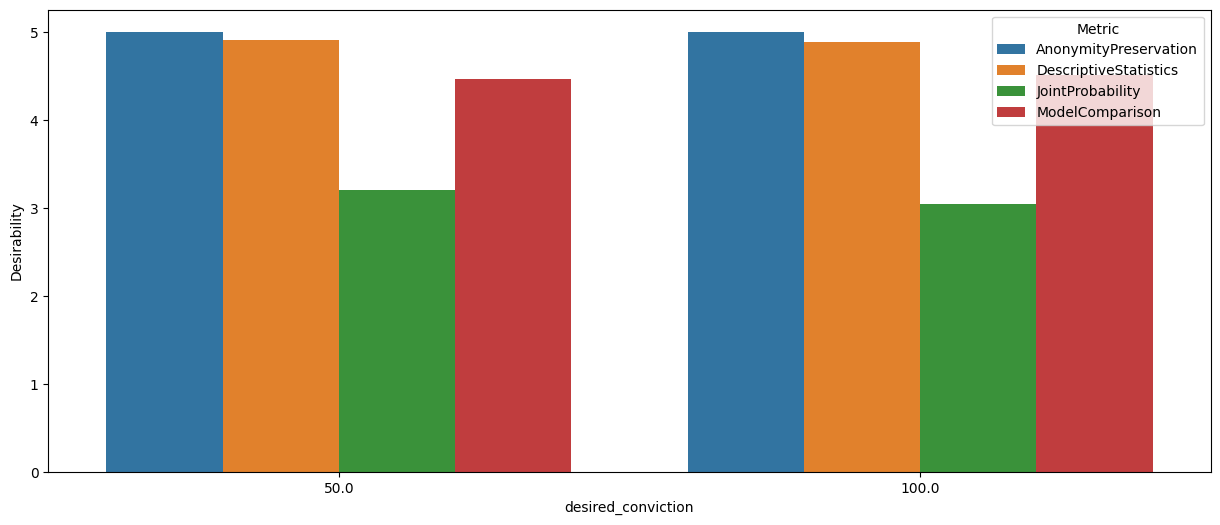

In [9]:
import matplotlib.pyplot as plt

# Melt the dataframe to long format
melted_df = final_result.melt(
    id_vars="desired_conviction",
    value_vars=metrics,
    var_name="Metric",
    value_name="Desirability"
)

# Create grouped bar chart
plt.figure(figsize=(15, 6))
sns.barplot(data=melted_df, x="desired_conviction", y="Desirability", hue="Metric")
plt.show()

nih_age Int64 21 90
nih_height Int64 48 80
nih_weight Int64 79 500
patient_stay_length Int64 0 151


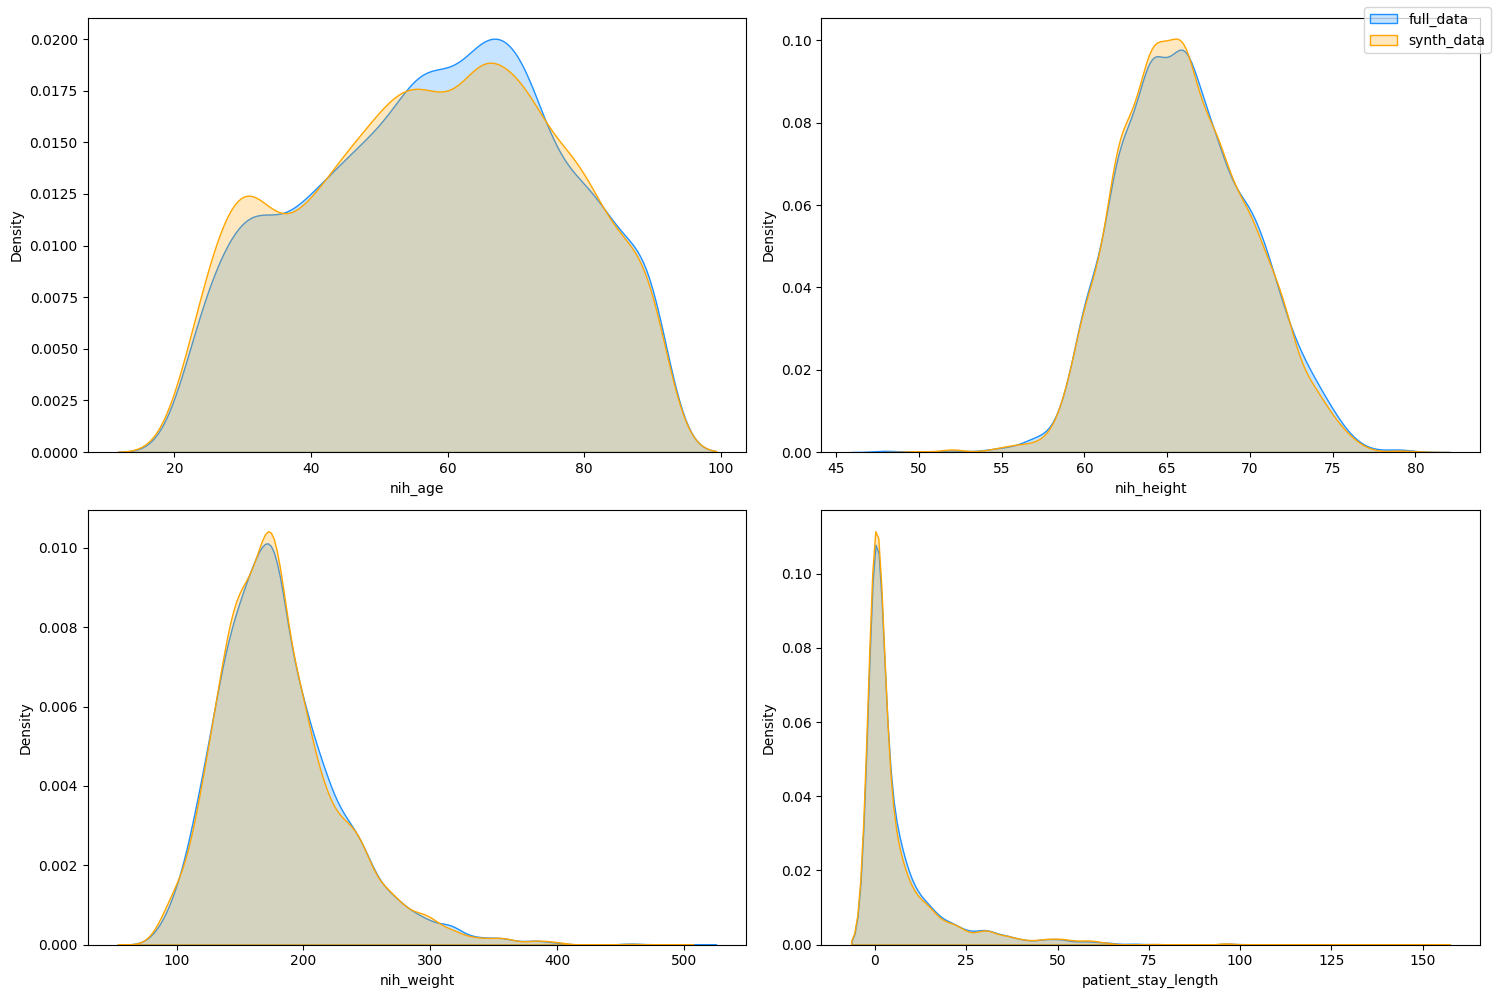

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
categorical_features = [f for f, a in features.items() if a["type"] in ("nominal", "ordinal")]

gen_df = synthed_dfs[-1]  # Using the one with the highest accuracy (theoretically)

for c, ax in zip(df.columns.drop(categorical_features), axes.flat):
    print(c, df[c].dtypes, df[c].min(), df[c].max())
    if df[c].dtypes != 'string':
        sns.kdeplot(ax=ax, x=df[c], color="dodgerblue", label="full_data", fill=True)
        sns.kdeplot(ax=ax, x=gen_df[c], color="orange", label="full_data", fill=True)
        ax.set_xlabel(c)

fig.legend(labels=["full_data", "synth_data"])
fig.tight_layout()
plt.show()

In [11]:
# Display the full ModelComparison results dataframe for the final run
with pd.option_context('display.max_rows', None):
    display(validator_results[-1]["ModelComparison"].get_dataframe())

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,nih_pregnancy,None,NaN,NaN
1,1,NaN,Howso,nih_pregnancy,None,NaN,NaN
2,1,original,Howso,country,accuracy,0.995882,5.000000
3,1,generated,Howso,country,accuracy,0.995882,5.000000
4,1,original,Howso,country,precision,0.991781,5.000000
5,1,generated,Howso,country,precision,0.991781,5.000000
6,1,original,Howso,country,recall,0.995882,5.000000
7,1,generated,Howso,country,recall,0.995882,5.000000
8,1,original,Howso,country,mcc,0.000000,5.000000
9,1,generated,Howso,country,mcc,0.000000,5.000000
